# Notebook to visualize and process LISST-VSF data

In [1]:
import os
import numpy as np
from scipy.interpolate import interp1d
opj = os.path.join
import xarray as xr
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib ipympl
from pylisst import calib,driver,process,utils
calfact = calib()


In [9]:
pkg_dir = '/DATA/instrument/lisst-vsf/pylisst'
dir = '/DATA/projet/gernez/hablab/'



file_ = 'V1111510.VSF'
#file_ = 'V1101425.VSF'
filez_ = 'Z1110820.VSF'
rep='raw'
file_ = 'V1081547.VSF'
filez_ = 'Z1071316.VSF'
rep='2023/lisst-vsf'
file = os.path.join(dir, rep,file_)
filez = os.path.join(dir, rep,filez_)
scat = driver(file)
scat.reader()
zsc = driver(filez)
zsc.reader()
plisst = process(scat, zsc, calfact)
plisst.full_process()

In [10]:
plisst.P11

<xarray.DataArray (set: 70, angles: 175)>
array([[ 1.75895727e+02,             nan,  1.12472525e+02, ...,
         3.65990240e-02,  3.36561524e-02,  2.93561221e-02],
       [ 1.60679288e+02,  1.60521611e+02,  1.86851927e+02, ...,
         2.25902748e-02,  2.29404633e-02,  2.17460332e-02],
       [ 1.62825171e+02,  1.11712619e+02,  1.75903445e+02, ...,
         2.36811819e-02,  2.18571844e-02,  1.93206400e-02],
       ...,
       [ 1.26949098e+02,  3.47771278e+02,  3.26225166e+02, ...,
         2.43144107e-02,  2.26283281e-02,  2.00374798e-02],
       [-2.53116640e+01,  3.78914276e+03,  3.56603527e+03, ...,
         1.76873528e-02,  1.53010490e-02,  1.15998348e-02],
       [            nan,  3.06468779e+02,  2.80454445e+02, ...,
         2.50567340e-02,  2.32967531e-02,  2.04830987e-02]])
Coordinates:
  * angles   (angles) float64 0.08803 0.1039 0.1226 0.1447 ... 154.0 155.0 156.0
  * set      (set) int64 0 1 2 3 4 5 6 7 8 9 ... 60 61 62 63 64 65 66 67 68 69
    pmt      (set) int64 510 400 400 400 400 400 400 ... 435 435 435 435 435 435

In [11]:
# set bead size radius:
rn_med =.5

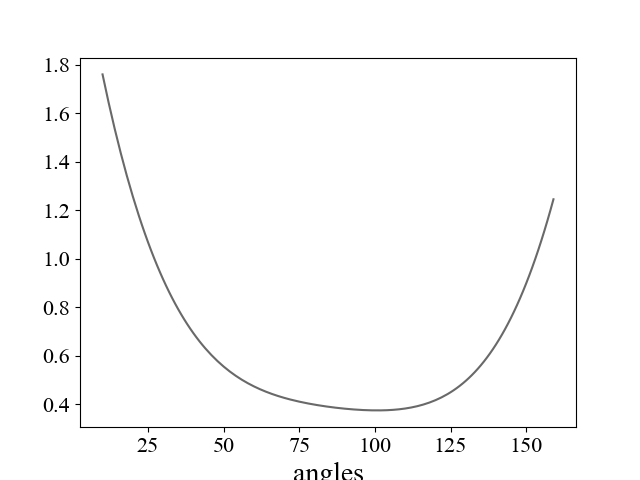

In [12]:
plisst.geom_corr.plot()
plt.show()

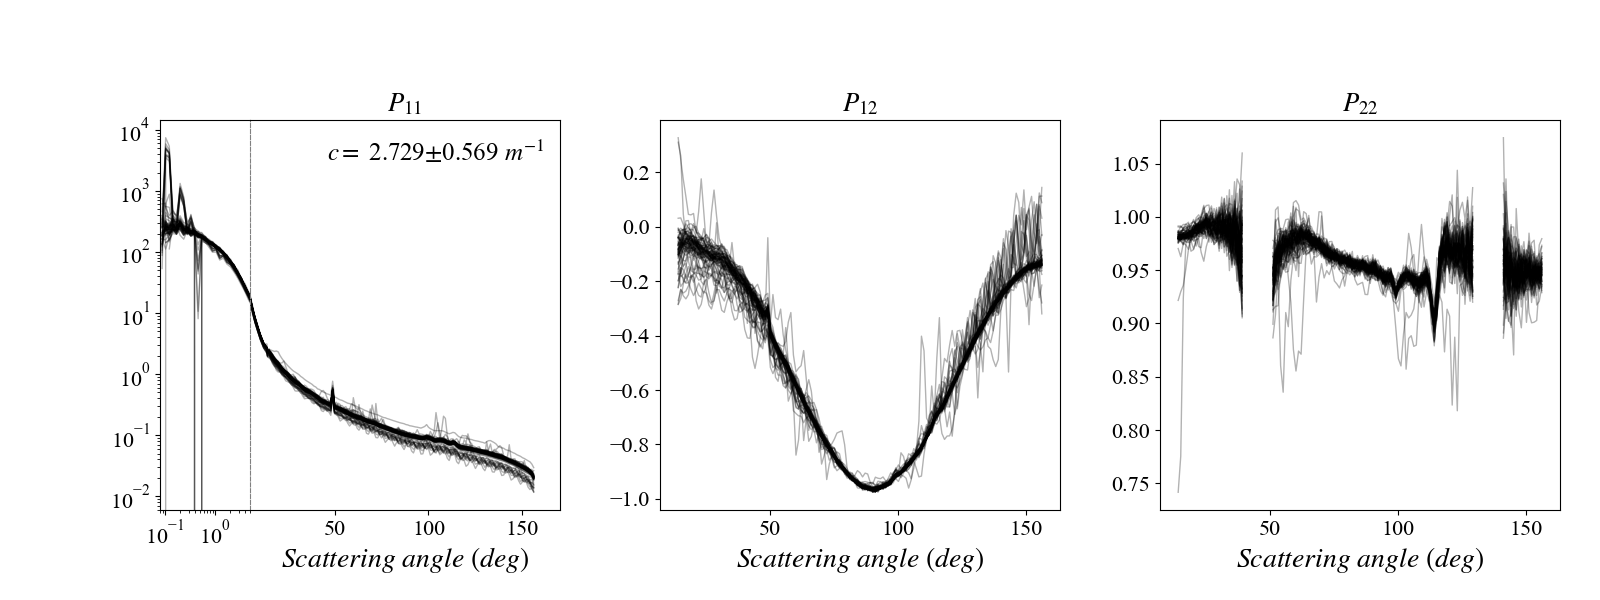

In [13]:
c_mean,c_median,c_std = float(plisst.beam_c.mean()),float(plisst.beam_c.median()), float(plisst.beam_c.std())

fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(16, 6), )
fig.subplots_adjust(bottom=0.15, top=0.8, left=0.1, right=0.975,
                    hspace=0.1, wspace=0.25)
axs = axs.ravel()
ax = axs[0]
ax.loglog()
ax, axlin = utils.plot().semilog(ax, size=3.1)
for ax_ in (ax, axlin):
    plisst.P11.plot(hue='set', color='black', alpha=0.3, lw=1, add_legend=False, ax=ax_)

plisst.p12.plot(hue='set', color='black', alpha=0.3, lw=1, add_legend=False, ax=axs[1])
plisst.p22.plot(hue='set', color='black', alpha=0.3, lw=1, add_legend=False, ax=axs[2])

axs[1].set_title('$P_{12}$')
axs[2].set_title('$P_{22}$')
for i in range(1, 3):
    axs[i].set_xlabel('$Scattering\ angle\ (deg)$')
axlin.text(0.95, 0.95,
           r'$c=${:6.3f}$\pm${:5.3f}'.format(c_median, c_std) + ' $m^{-1}$',
           size=18, transform=axlin.transAxes, ha="right", va="top", )
axlin.xaxis.set_visible(True)
ax.set_xlabel('')
axlin.set_xlabel('$Scattering\ angle\ (deg)$')
axlin.set_title('$P_{11}$')

plt.show()

In [14]:
mie=True
if mie:
    from mie_perso import psd, mie_multiprocess

    # ---------------------------------
    # get Mie simulations
    # ---------------------------------
    pmie = mie_multiprocess.processor()
    size_param = psd.size_param
    psd_ = psd.psd()

    # -------------------------------------
    # Generate mueller matrices for a series
    # of size parameters x = np.pi * diameter / wavelength (unitless)
    # -------------------------------------
    wl = 515
    nMedium = 1.3199 + 6878 / wl ** 2 - 1.132e9 / wl ** 4 + 1.11e14 / wl ** 6
    wl_medium = wl / nMedium
    npolystyrene = 1.60
    m = npolystyrene / nMedium - 0.000j

    theta = np.linspace(0, np.pi, 3600)
    x = np.logspace(np.log10(1), 2, 1001)
    ofile = opj(pkg_dir,'data','mueller_mie_' + format(m, '1.3f') + '_t3600.nc')
    if os.path.exists(ofile):
        print(ofile)

/DATA/instrument/lisst-vsf/pylisst/data/mueller_mie_1.198+0.000j_t3600.nc


In [40]:
if mie:
    if os.path.exists(ofile):
        mueller = xr.open_dataset(ofile)
    else:
        mueller = pmie.ScatMat_mp(m, x, theta)
        mueller.to_netcdf(ofile)

    # -------------------------------------
    # convert mueller matrices for a series
    # of diameters for a given couple of
    # wavelength (in vacuum) and refractive index (in medium)
    # for a medium of refractive index nMedium
    # -------------------------------------
    theta = mueller.theta
    ang = theta * 180. / np.pi
    Ntheta = len(mueller.theta)

    m = complex(mueller.nr, mueller.ni)


    m_vacuum = m * nMedium
    wl_medium = wl / nMedium

    dpnm = mueller.x * wl_medium / np.pi
    dp = dpnm / 1000

    CV = 0.01
    sig = rn_med * CV
    rv_med = psd_.rnmed2rvmed(rn_med, sig)

    ndp = psd_.lognorm(dp / 2, rn_med=rn_med, sigma=sig)
    # ndp = modif_power_law(dp / 2, slope=-slope, rmin=rmin, rmax=rmax)
    # convert to xarray
    ndp = dp.copy(data=ndp)

    # ndp = psd #[:-1]*np.diff(dp/2)
    S11, S12, S33, S34 = np.zeros(Ntheta), np.zeros(Ntheta), np.zeros(Ntheta), np.zeros(Ntheta)

    # aSDn = np.pi*((dp/2)**2)*ndp
    aSDn = ndp
    S11 = np.trapz(mueller.S11 * aSDn, dp, axis=0)
    S12 = np.trapz(mueller.S12 * aSDn, dp, axis=0)/S11
    S33 = np.trapz(mueller.S33 * aSDn, dp, axis=0)/S11
    S34 = np.trapz(mueller.S34 * aSDn, dp, axis=0)/S11
    norm = np.trapz(S11 * np.sin(theta), theta) / 2


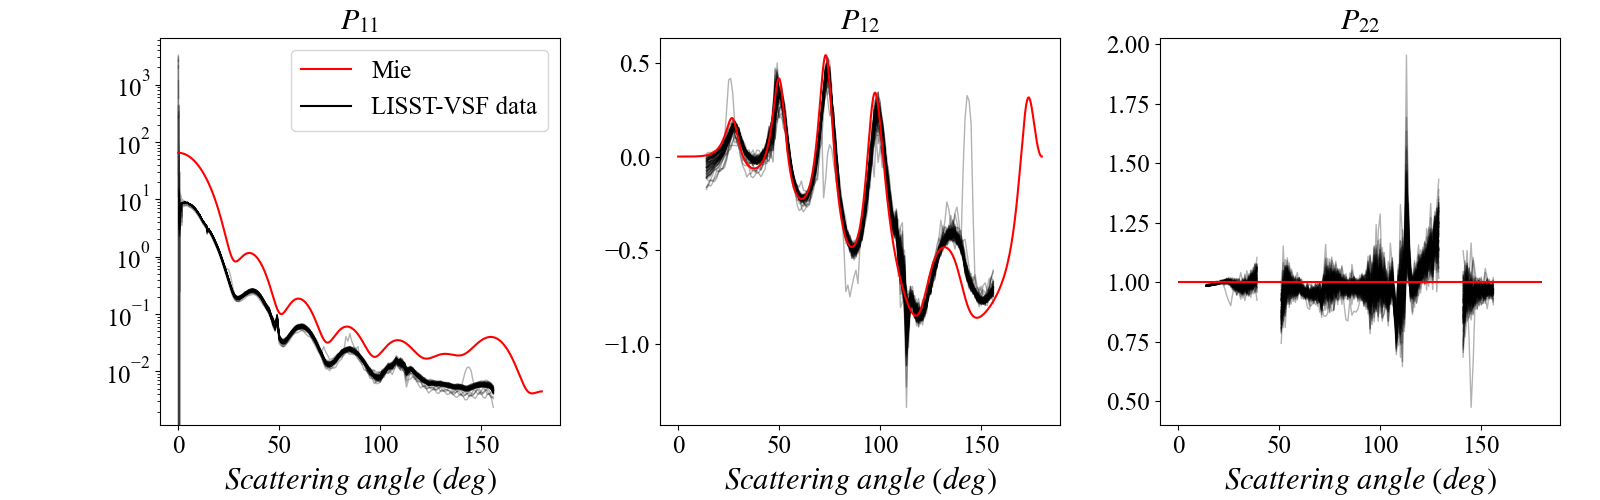

In [41]:
from matplotlib.lines import Line2D

fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(16, 5), sharex=True)
fig.subplots_adjust(bottom=0.15, top=0.925, left=0.1, right=0.975,
                    hspace=0.1, wspace=0.25)
axs = axs.ravel()
plisst.P11.plot(hue='set', color='black', alpha=0.3, lw=1, add_legend=False, ax=axs[0])

plisst.p12.plot(hue='set', color='black', alpha=0.3, lw=1, add_legend=False, ax=axs[1])
plisst.p22.plot(hue='set', color='black', alpha=0.3, lw=1, add_legend=False, ax=axs[2])

axs[0].plot(ang,S11/norm,c='red',label='Mie')
axs[1].plot(ang,S12,c='red')
axs[2].hlines(1,0,180,colors='red')
axs[0].set_title('$P_{11}$')
axs[1].set_title('$P_{12}$')
axs[2].set_title('$P_{22}$')
for i in range(3):
    axs[i].set_xlabel('$Scattering\ angle\ (deg)$')
axs[0].semilogy()
handles, labels = axs[0].get_legend_handles_labels()
patch = Line2D([0],[0],color='black', label='LISST-VSF data')
handles.append(patch)
axs[0].legend(handles=handles, loc='upper right')
plt.show()

In [27]:


fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(16, 5), sharex=True)
fig.subplots_adjust(bottom=0.125, top=0.95, left=0.05, right=0.975,
                    hspace=0.1, wspace=0.25)
axs = axs.ravel()
b.P11.plot(hue='set', color='black', alpha=0.3, lw=1, add_legend=False, ax=axs[0])
b.p12.plot(hue='set', color='black', alpha=0.3, lw=1, add_legend=False, ax=axs[1])
b.p22.plot(hue='set', color='black', alpha=0.3, lw=1, add_legend=False, ax=axs[2])

axs[0].semilogy()
for i in range(3):
    axs[i].minorticks_on()
plt.show()

NameError: name 'b' is not defined